In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from skimage import io
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import progressbar
import time
import warnings
warnings.filterwarnings('ignore')

/home/tihon/ml/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
pic_dir_path = '../data/img2'
json_dir_path = '../data/ann2'
MODEL_PATH = '../data/model_artif/'

PIXEL_COUNT = 480 * 640
LABEL_COUNT = 4

EPOCH = 30

In [21]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [22]:
def read_img(img_path):
    return io.imread(img_path)[:, :, :3] / 255

def read_collection(img_paths):
    n_imgs = img_paths.shape[0]
    output = np.zeros((n_imgs, 480, 640, 3), dtype='float32')
    
    for i, path in enumerate(img_paths):
        output[i, :, :, :] = read_img(path)
    
    return output

In [23]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed

In [24]:
def mse(expected, predicted):
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)

def weight_variable(name, shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.get_variable(name, initializer=initial)

def bias_variable(name, shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable(name, initializer=initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [25]:
class Model(object):
    xxx = 0
    
# Build neural network
def build_model():
    x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT, 3])
    y_placeholder = tf.placeholder(tf.float32, shape=[None, LABEL_COUNT])

    x_image = tf.reshape(x_placeholder, [-1, 480, 640, 3])
    # Convolution Layer 1
    W_conv1 = weight_variable("w1", [3, 3, 3, 32])
    b_conv1 = bias_variable("b1", [32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    # Convolution Layer 2
    W_conv2 = weight_variable("w2", [3, 3, 32, 64])
    b_conv2 = bias_variable("b2", [64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    # Convolution Layer 3
    W_conv3 = weight_variable("w3", [3, 3, 64, 128])
    b_conv3 = bias_variable("b3", [128])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    # Dense layer 1
    h_pool3_flat = tf.reshape(h_pool3, [-1, 60*80*128])
    W_fc1 = weight_variable("w4", [60*80*128, 500])
    b_fc1 = bias_variable("b4", [500])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)   
    # Dense layer 2
    W_fc2 = weight_variable("w5", [500, 500])
    b_fc2 = bias_variable("b5", [500])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)  
    # Output layer
    W_out = weight_variable("w6", [500, LABEL_COUNT])
    b_out = bias_variable("b6", [LABEL_COUNT])
    
    output = tf.matmul(h_fc2, W_out) + b_out
    
    model = Model()
    model.x_placeholder = x_placeholder
    model.y_placeholder = y_placeholder
    model.output = output
    
    return model

In [26]:
img_names = np.array(os.listdir(pic_dir_path))
json_names = os.listdir(json_dir_path)

In [27]:
img = io.imread('../data/img2/' + img_names[10])
img.shape

(480, 640, 4)

In [28]:
for i, name in enumerate(json_names):
    json_names[i] = os.path.join(json_dir_path, name)

In [29]:
info = []
for name in json_names:
    f = open(name, 'r')
    f_json = json.load(f)
    info += f_json[0]['imgs']

info = np.array(info)

In [30]:
info.shape[0]

10001

In [31]:
info[0]

{'background_pic': '1277383267Image000041.jpg',
 'car_number': 'P252OO53',
 'car_number_pic': 'P252OO53.png',
 'coordinates': [444, 3, 550, 26]}

In [32]:
# X_paths = []
X = np.zeros((1001, 480, 640, 3), dtype='float32')
Y = np.zeros((1001, 4), dtype=int)

In [33]:
info1001 = info[:1001]
bar = progressbar.ProgressBar(max_value=info1001.shape[0])

for i, inf in enumerate(info1001):
    path = os.path.join(pic_dir_path, inf['car_number_pic'])
    img = io.imread(path)[:, :, :3] / 255
    X[i, :, :, :] = img
    # X_paths.append(path)
    Y[i, :] = inf['coordinates']
    bar.update(i)

# X_paths = np.array(X_paths)

 99% (999 of 1001) |#################### | Elapsed Time: 0:00:42 ETA:   0:00:00

In [34]:
X.shape, Y.shape

((1001, 480, 640, 3), (1001, 4))

In [35]:
X_train = X[:901, :, :, :]
X_test = X[901:, :, :, :]

Y_train = Y[:901, :]
Y_test = Y[901:, :]

X2_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2],  X_train.shape[3])
X2_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2],  X_test.shape[3])

Y2_train = Y_train / (64.0, 32.0, 64.0, 32.0) - 1.0
Y2_test = Y_test / (64.0, 32.0, 64.0, 32.0) - 1

dataset = Dataset(X2_train, Y2_train)

In [36]:
X2_train.shape, Y2_train.shape, X2_test.shape, Y2_test.shape

((901, 307200, 3), (901, 4), (100, 307200, 3), (100, 4))

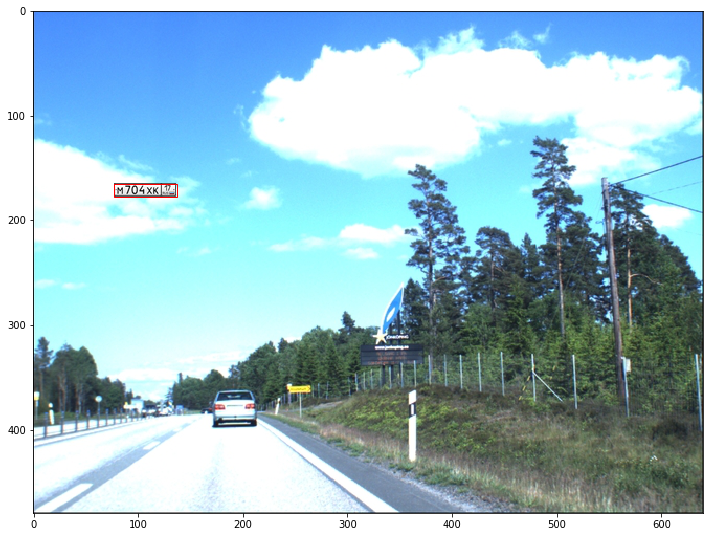

In [38]:
plt.figure(figsize=(12, 16))
plt.imshow(X_train[1])
coordinats = Y_train[1]
rect = Rectangle(
    (coordinats[0], coordinats[1]), 
    coordinats[2] - coordinats[0], 
    coordinats[3] - coordinats[1],
    color='r', fill=False
)
gca = plt.gca()
gca.add_patch(rect)

In [ ]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    
    model = build_model()
    loss = mse(model.y_placeholder, model.output)
    
    saver = tf.train.Saver()
    start_time = time.time()
    best_score = 1

    train_step = tf.train.RMSPropOptimizer(learning_rate=0.1).minimize(loss)

    session = tf.InteractiveSession()
    session.run(tf.global_variables_initializer())
    #saver.restore(session, os.path.join(MODEL_PATH, "model"))

    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={model.x_placeholder: batch_x, model.y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch:
            last_epoch = dataset.epoch_completed()
            score_test = loss.eval(feed_dict={model.x_placeholder: X2_test, model.y_placeholder: Y2_test})
            if score_test < best_score:
                best_score = score_test
                saver.save(session, os.path.join(MODEL_PATH, "model"))
            if dataset.epoch_completed() % 1 == 0:
                epm = 60 * dataset.epoch_completed() / (time.time()-start_time)
                print('Epoch: %d, Score: %f, Epoch per minute: %f' % (dataset.epoch_completed(), score_test, epm))
    print('Finished in %f seconds.' % (time.time()-start_time)) 
    
    session.close()